In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy import signal
import librosa

In [2]:
"""
# Download data to your colab instance
!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/data/nsynth_valid.mp3
!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/data/nsynth_test.mp3
!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/labels_valid.txt
!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/labels_test.txt    
"""

'\n# Download data to your colab instance\n!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/data/nsynth_valid.mp3\n!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/data/nsynth_test.mp3\n!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/labels_valid.txt\n!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/labels_test.txt    \n'

## Constant-Q Transform Code

Translated code from <a href = "https://tomohikonakamura.github.io/Tomohiko-Nakamura/">Tomohiko Nakamura</a> from <a href = "http://dafx14.fau.de/papers/dafx14_tomohiko_nakamura_fast_signal_reconstructio.pdf">this paper</a>




In [3]:
"""
Translated matlab code from Tomohiki Nakamura Copyright (c) 2015
Translation copyright Chris Tralie (c) 2022
"""

nextpow2 = lambda x: int(np.ceil(np.log2(x)))

def lognormal_wavelet(a, sigma, T, P, alpha):
    """
    Return DFTs of scaled log-normal wavelets

    Parameters
    ----------
    a: ndarray(K)
        scales
    sigma: float
        Variance
    T: int
        Signal length
    P: float
        Bandwidth parameter for fast approximate consant-Q
        transform.  Elements of range [-P\sigma, P\sigma] are used
    alpha: float
        Log-normal wavelet parameter.  For example, if alpha=1 (2),
        time slice of magnitude (squared, resp.) wavelet transform
        of a sinusoid approximately equals a Gaussian-like function
    
    Returns
    -------
    w: ndarray(K, n_time_shifts)
        Wavelets
    leftside: ndarray(K, dtype=int)
        Left side fo computed range in the angular linear frequency domain
    sumfilout: ndarray(T//2+1)
        Normalization constant for inverse transform
    """
    K = len(a) # Num of scales
    delta_rad = 2*np.pi/T # Radians
    center_omega = 1/a # Radians
    calculate_range = np.exp([np.log(center_omega)-P*sigma, np.log(center_omega)+P*sigma])
    calculate_index = np.floor(calculate_range/delta_rad).astype(int) # Linear frequency index
    leftside = calculate_index[0, :]
    leftside[leftside < 0] = 0

    # Linear frequency index size (length of the longest wavelet)
    mx = np.max(calculate_index[1, :] - calculate_index[0, :])
    D = 2**nextpow2(mx) 
    D = int(D)
    calculate_omega = np.array(leftside[:, None] + np.arange(D)[None, :], dtype=float)
    calculate_omega *= delta_rad # Radians (K x D)
    w = np.exp(-np.log(calculate_omega*a[:, None])**2/(2*alpha*sigma**2))
    w *= (calculate_omega > 0)*(calculate_omega <= np.pi)

    # Summation of filter outputs
    sumfilout = np.zeros(T)
    for k in range(K):
        sumfilout[leftside[k]:leftside[k]+D] += np.abs(w[k, :])**2
    sumfilout = sumfilout[0:T//2+1]
    return w, leftside, sumfilout


class CQT:
    def __init__(self, T, sr, resol=24, LF=27.5, P=1.0, alpha=1.0, sigma=0.02):
        """
        Parameters
        ----------
        T: int
            Signal length
        sr: int
            Sampling frequency
        resol: int
            Number of frequency bins in each octave
        LF: float
            Lowest center frequency
        P: float
            Bandwidth parameter for fast approximate consant-Q
            transform.  Elements of range [-P\sigma, P\sigma] are used
        alpha: float
            Log-normal wavelet parameter.  For example, if alpha=1 (2),
            time slice of magnitude (squared, resp.) wavelet transform
            of a sinusoid approximately equals a Gaussian-like function
        """
        max_n = np.floor(np.log2(sr/2/LF)*resol) # number of frequency bins
        analysis_freq = LF*2**(np.arange(max_n+1)/resol); # center frequencies
        a = sr/(2*np.pi*analysis_freq) # corresponding scales
        w, leftside, sumfilout = lognormal_wavelet(a,sigma,T,P,alpha)
        D = w.shape[1]

        # Normalization for CQT
        sumfilout2 = np.array(sumfilout)
        sumfilout2[sumfilout < 1e-4] = 1e10
        norm_C = np.zeros(T)
        norm_C[0:sumfilout2.size] = 1/sumfilout2
        if T%2 == 0:
            norm_C[T//2::] = 0
        else:
            norm_C[int(np.ceil(T/2))-1::] = 0

        # Save away local variables
        self.resol = resol
        self.sigma = sigma
        self.a = a
        self.w = w
        self.L = leftside
        self.calculate_indexes = self.L[:, None] + np.array(np.arange(D)[None, :], dtype=int)
        self.T = T
        self.sr = sr
        self.timeshift = T/sr/D
        self.index2time = self.timeshift*np.arange(D)
        self.index2freqHz = analysis_freq
        self.sumfilout = sumfilout
        self.norm_C = norm_C

    def forward(self, x):
        """
        Perform a forward fast wavelet transform on a signal of compatible length

        Parameters
        ----------
        x: ndarray(T)
            Signal
        """
        T = self.T; assert(x.size == T)
        D = self.w.shape[1]
        FTx1 = np.fft.fft(x)
        FTx1[T//2::] = 0
        spec = FTx1[self.calculate_indexes]*self.w
        spec = np.fft.ifft(spec, axis=1)
        spec *= np.exp(1j*2*np.pi*self.L[:, None]*np.arange(D)[None, :]/D)
        return spec
    
    def inverse(self, S):
        K = S.shape[0]
        assert(K == self.w.shape[0])
        D = self.w.shape[1]
        assert(D == self.w.shape[1])
        L = self.L
        S = S*np.exp(-1j*2*np.pi*self.L[:, None]*np.arange(D)[None, :]/D)
        S = np.fft.fft(S, axis=1)*np.conj(self.w)
        # Now do shift overlap/add
        spec = np.zeros(self.T, dtype=S.dtype)
        for k in range(K):
            spec[L[k]:L[k]+D] += S[k, :]
        spec = spec*self.norm_C
        n = spec.size//2
        spec[n+1::] = np.conj(spec[1:n][::-1])
        return np.fft.ifft(spec)
    
    def griffin_lim(self, S, n_iters=20):
        """
        Perform Griffin-Lim phase retrieval on a magnitude
        CQT-spectrogram S
        """
        A = np.array(S, dtype=complex)
        A = A*np.exp(1j*2*np.pi*np.random.rand(A.shape[0], A.shape[1]))
        for i in range(n_iters):
            print(".", end='')
            P = self.forward(np.real(self.inverse(A)))
            angle = np.arctan2(np.imag(P), np.real(P))
            A = S*np.exp(1j*angle)
        return np.real(self.inverse(A))

## Data Loader

In [4]:
LABELS = ['bass_electronic', 'bass_synthetic', 'brass_acoustic', 
          'flute_acoustic', 'flute_synthetic', 'guitar_acoustic', 
          'guitar_electronic', 'keyboard_acoustic', 
          'keyboard_electronic', 'keyboard_synthetic', 
          'mallet_acoustic', 'organ_electronic', 'reed_acoustic', 
          'string_acoustic', 'vocal_acoustic', 'vocal_synthetic']

LABEL2IDX = {s:i for i, s in enumerate(LABELS)}

class Synth(Dataset):
    def __init__(self, audio_filename, labels_filename, instrument, cqt, sample_len=4):
        """
        Parameters
        ----------
        audio_filename: string
            Path to audio file
        labels_filename: string
            Path to labels file
        instrument: string
            Which instrument to include
        cqt: CQT
            CQT object
        sample_len: int
            Length of each sample, in seconds
        """
        self.x, self.sr = librosa.load(audio_filename, sr=sr)
        self.labels = np.loadtxt(labels_filename)
        print("Finished loading audio ", audio_filename)
        self.sample_len = sample_len
        label = LABEL2IDX[instrument]
        self.idxsub = np.arange(len(self.labels))[self.labels == label]
        self.sr = cqt.sr
        self.cqt = cqt
    
    def __len__(self):
        return len(self.idxsub)
    
    def __getitem__(self, idx):
        """
        Return a tuple (CQT, x)
        """
        idx = self.idxsub[idx]
        L = self.sr*self.sample_len
        x = self.x[L*idx:L*idx+self.sr]
        S = np.abs(self.cqt.forward(x))
        S = torch.from_numpy(np.array(S, dtype=np.float32))
        x = torch.from_numpy(np.array(x, dtype=np.float32))
        return S.view(1, S.shape[0], S.shape[1]), x.view(1, x.shape[0])
    
    


In [5]:
sr = 8000
sample_len = 4
cqt = CQT(sr, sr)

data = Synth("nsynth_valid.mp3", "labels_valid.txt", "bass_synthetic", cqt, sample_len)

Finished loading audio  nsynth_valid.mp3


In [6]:
class AutoencoderCNN(nn.Module):
    def __init__(self, X, device, depth=4, dim_latent=2):
        """
        X: an example batch
        device: device
        """
        super(AutoencoderCNN, self).__init__()
        
        ## Step 1: Create the convolutional down layers
        last_channels = 1
        channels = 32
        down = []
        for i in range(depth):
            conv = nn.Conv2d(last_channels, channels, 3, stride=2, padding=1)
            conv = conv.to(device)
            last_channels = channels
            channels *= 2
            down.append(conv)
            down.append(nn.LeakyReLU().to(device))
        y = X
        for layer in down:
            y = layer(y)
        shape = y.shape[1::]
        down.append(nn.Flatten())
        y = down[-1](y)
        dim = y.shape[-1]
        self.down = nn.Sequential(*down)
        
        ## Step 2: 
        self.latentdown = nn.Sequential(nn.Linear(dim, dim_latent), nn.LeakyReLU()).to(device)
        self.latentup = nn.Sequential(nn.Linear(dim_latent, dim), nn.LeakyReLU()).to(device)
        
        up = [nn.Unflatten(1, shape)]
        channels = last_channels//2
        for i in range(depth):
            upsample = nn.Upsample(scale_factor=2, mode='bilinear').to(device)
            convup = nn.Conv2d(last_channels, channels, 3, stride=1, padding=1)
            convup = convup.to(device)
            up.append(upsample)
            up.append(convup)
            up.append(nn.LeakyReLU().to(device))
            last_channels = channels
            if i == depth-2:
                channels = 1
            else:
                channels = channels // 2
        self.up = nn.Sequential(*up)
    
    def forward(self, x, verbose=False):
        y = x
        if verbose:
            print(y.shape)
        for layer in self.down + self.latentdown + self.latentup + self.up:
            y = layer(y)
            if verbose:
                print(y.shape)
        return y
    
    def encode(self, x):
        return self.latentdown(self.down(x))
    
    def decode(self, x):
        return self.up(self.latentup(x))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
loader = DataLoader(data, batch_size=64, shuffle=True)
X = next(iter(loader))[0].to(device)
model = AutoencoderCNN(X, device, depth=6, dim_latent=2)
model(X, True);

torch.Size([64, 1, 173, 256])
torch.Size([64, 32, 87, 128])
torch.Size([64, 32, 87, 128])
torch.Size([64, 64, 44, 64])
torch.Size([64, 64, 44, 64])
torch.Size([64, 128, 22, 32])
torch.Size([64, 128, 22, 32])
torch.Size([64, 256, 11, 16])
torch.Size([64, 256, 11, 16])
torch.Size([64, 512, 6, 8])
torch.Size([64, 512, 6, 8])
torch.Size([64, 1024, 3, 4])
torch.Size([64, 1024, 3, 4])
torch.Size([64, 12288])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 12288])
torch.Size([64, 12288])
torch.Size([64, 1024, 3, 4])
torch.Size([64, 1024, 6, 8])
torch.Size([64, 512, 6, 8])
torch.Size([64, 512, 6, 8])
torch.Size([64, 512, 12, 16])
torch.Size([64, 256, 12, 16])
torch.Size([64, 256, 12, 16])
torch.Size([64, 256, 24, 32])
torch.Size([64, 128, 24, 32])
torch.Size([64, 128, 24, 32])
torch.Size([64, 128, 48, 64])
torch.Size([64, 64, 48, 64])
torch.Size([64, 64, 48, 64])
torch.Size([64, 64, 96, 128])
torch.Size([64, 32, 96, 128])
torch.Size([64, 32, 96, 128])
torch.Size([64, 32, 192, 256])
tor

Epoch 0, loss 14270882.834
Epoch 1, loss 7852823.506
Epoch 2, loss 7419093.975
Epoch 3, loss 6900185.230
Epoch 4, loss 6641701.771
Epoch 5, loss 6486289.865
Epoch 6, loss 6430186.523
Epoch 7, loss 6351203.975
Epoch 8, loss 6335588.381
Epoch 9, loss 6284777.980
Epoch 10, loss 6284176.461
Epoch 11, loss 6237854.074
Epoch 12, loss 6245298.867
Epoch 13, loss 6222311.904
Epoch 14, loss 6205600.443


KeyboardInterrupt: 

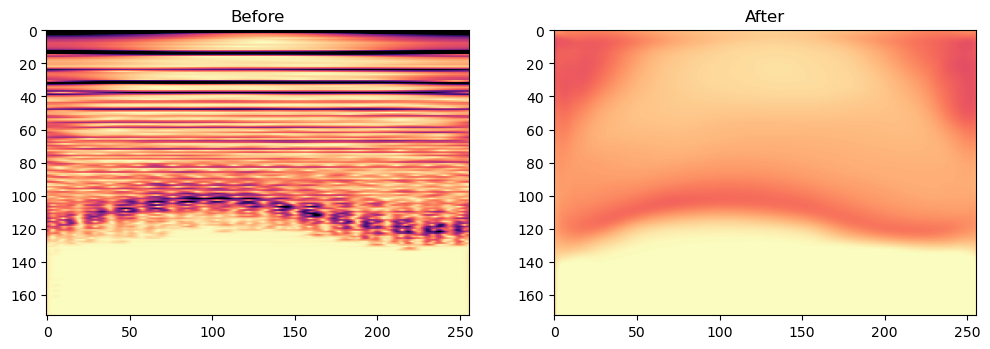

In [7]:
# Try to use the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

## Step 2: Create model with a test batch
loader = DataLoader(data, batch_size=64, shuffle=True)
X = next(iter(loader))[0].to(device)

model = AutoencoderCNN(X, device, depth=7, dim_latent=10)


## Step 3: Setup the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100 # Each "epoch" is a loop through the entire dataset
# and we use this to update the parameters
losses = []
accuracy = []
train_losses = []
train_accuracy = []
plt.figure(figsize=(12, 6))
for epoch in range(n_epochs):
    loader = DataLoader(data, batch_size=16, shuffle=True)
    train_loss = 0
    for X, _ in loader: # Go through each mini batch
        # Move inputs/outputs to GPU
        X = X.to(device)
        # Reset the optimizer's gradients
        optimizer.zero_grad()
        # Run the sequential model on all inputs
        X_est = model(X)
        X_est = X_est[:, :, 0:X.shape[2], 0:X.shape[3]]
        # Compute the loss function comparing Y_est to Y
        loss = torch.sum(torch.abs(X_est - X))
        #loss = torch.sum(torch.abs(torch.log10(X_est+0.1) - torch.log10(X+0.1)))
        # Compute the gradients of the loss function with respect
        # to all of the parameters of the model
        loss.backward()
        # Update the parameters based on the gradient and
        # the optimization scheme
        optimizer.step()
        train_loss += loss.item()
    
    
    X = X.detach().cpu()
    X_est = X_est.detach().cpu()
    
    plt.clf()
    plt.subplot(121)
    plt.imshow(X[0, 0, :, :], cmap='magma_r', vmin=0, vmax=1)
    plt.title("Before")
    plt.subplot(122)
    plt.imshow(X_est[0, 0, :, :], cmap='magma_r', vmin=0, vmax=1)
    plt.title("After")
    plt.savefig("Epoch{}.png".format(epoch))
    
    print("Epoch {}, loss {:.3f}".format(epoch, train_loss))
    train_losses.append(train_loss)

In [8]:
X, audio = next(iter(loader))
X_est = model(X.to(device))
X_est = X_est[:, :, 0:X.shape[2], 0:X.shape[3]]
X = X.detach().cpu()
X_est = X_est.detach().cpu()

Text(0.5, 1.0, 'After')

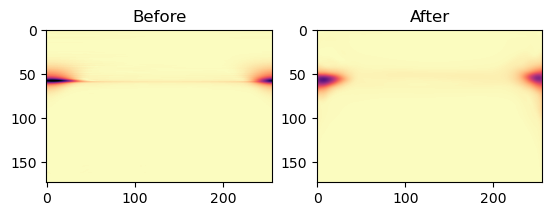

In [24]:
idx = 4

plt.clf()
plt.subplot(121)
#plt.imshow(torch.log10(X[5, 0, :, :]+0.1))
plt.imshow(X[idx, 0, :, :], cmap='magma_r', vmin=0, vmax=1)
plt.title("Before")
plt.subplot(122)

#plt.imshow(torch.log10(X_est[5, 0, :, :]+0.1))
plt.imshow(X_est[idx, 0, :, :], cmap='magma_r', vmin=0, vmax=1)
plt.title("After")

In [25]:
x1 = audio[idx][0]
ipd.Audio(x1, rate=sr)

In [27]:
x2 = cqt.inverse(X[idx, 0, :, :])
ipd.Audio(x2, rate=sr)

In [26]:
x2 = cqt.inverse(X_est[idx, 0, :, :])
ipd.Audio(x2, rate=sr)